# Quantifying uncertainty with a Gaussian Process

This is a toy regression problem to illustrate how a Gaussian Process (GP) estimates uncertainty with its predictions.

Code from [GPyTorch examples](https://gpytorch.ai/).

In [1]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import torch.nn as nn
import random

In [2]:
def gt_func(x):
    return (10 - 0.2 * x**3 + 0.5*x - 1.2* x**2 + 0.08 * x**4) ** 0.4

In [3]:
xgt = torch.arange(-7,7,0.02)

In [4]:
ygt = gt_func(xgt)

In [5]:
xdata = torch.Tensor([-5, -4, -3.5, -0.5, 0.5, 2.5, 3, 4, 4.5])
ydata = gt_func(xdata)

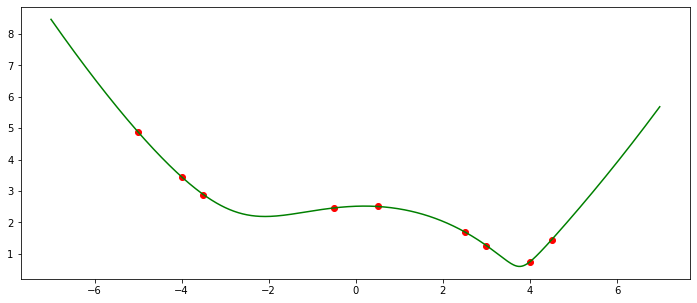

In [6]:
plt.figure(figsize=(12,5))
plt.plot(xgt,ygt, color='green')
plt.scatter(xdata, ydata, color='red')
plt.savefig("ground-truth-only.png")
plt.show()

In [7]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [8]:
def train_gp(train_x, train_y, training_iter:int=150, verbose:bool=False):
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()
        
    return model, likelihood

In [9]:
def eval_gp(model, likelihood, lo:float=-7, hi:float=7) -> [Tensor, Tensor]:
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(lo, hi, 1000)
        observed_pred = likelihood(model(test_x))
    return test_x, observed_pred

In [10]:
def plot_gp(xgt, ygt, train_x, train_y, test_x, observed_pred, filename:str=None):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(12, 6))
        

        ax.plot(xgt, ygt, 'g-')
        plt.ylim(0,9)
        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as red stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'r*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        #ax.set_ylim([-3, 3])
        ax.legend(['Ground Truth', 'Observed Data', 'Mean', 'Confidence'])
        if filename:
            plt.savefig(filename)
        plt.show()

[7, 1, 5, 6, 2, 3, 8, 4, 0]


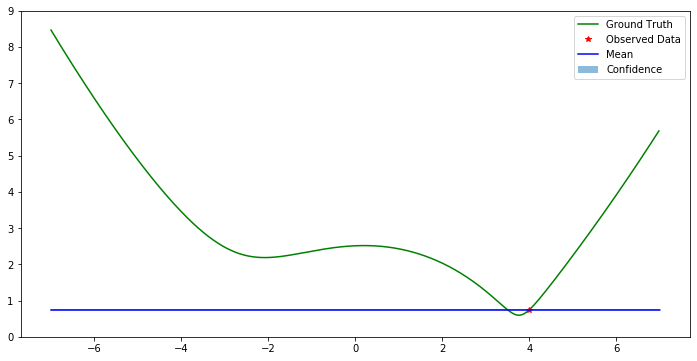

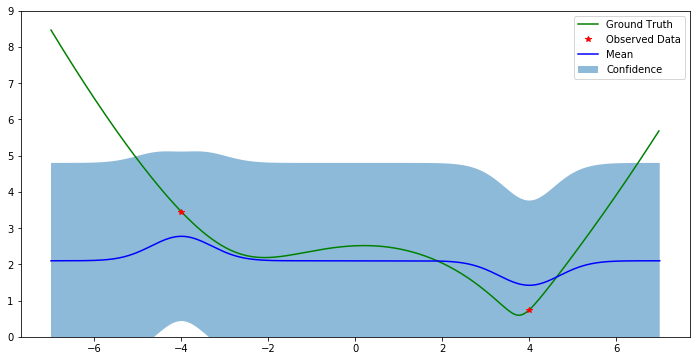

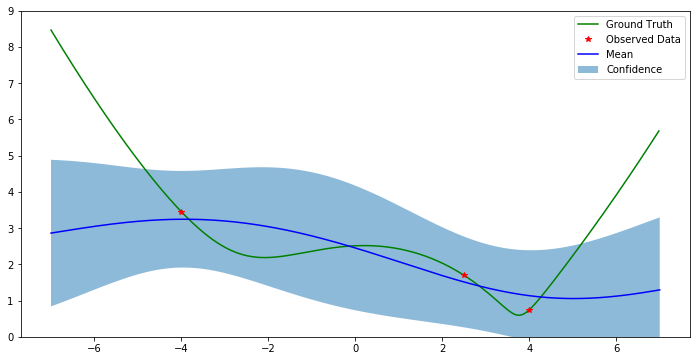

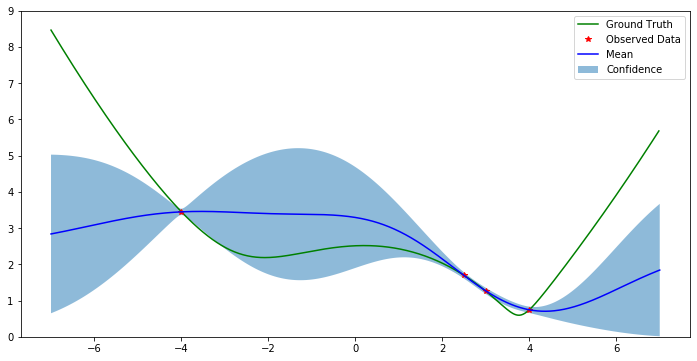

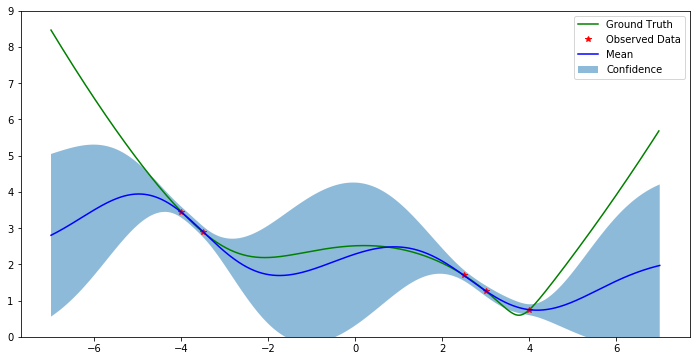

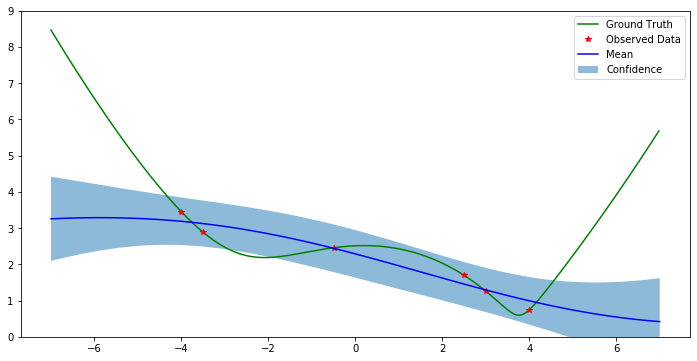

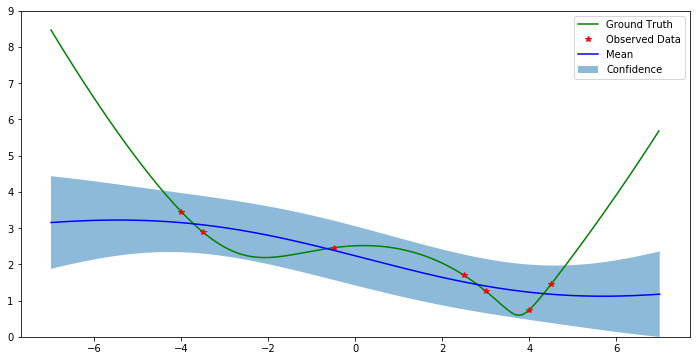

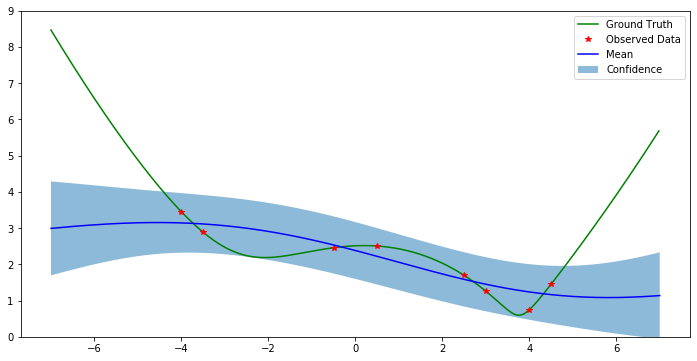

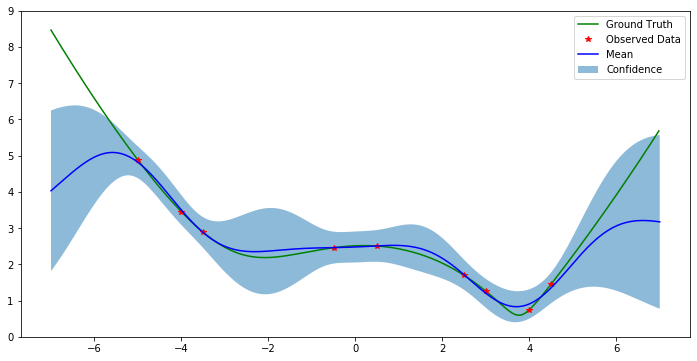

In [11]:
N = len(xdata)
order = list(range(N))
random.seed(123)
random.shuffle(order)
#order = [7, 1, 5, 6, 2, 3, 8, 4, 0]
print(order)
for i in range(N):
    idx = order[:(i+1)]
    x = xdata[idx]
    y = ydata[idx]
    
    model, likelihood = train_gp(x,y)
    testx, obs = eval_gp(model, likelihood)
    plot_gp(xgt, ygt, x, y, testx, obs, f"gp-{i+1}.png")